In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn

In [2]:
#load our train dataset.
train = pd.read_csv("~/datasets/mnist/train.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Splitting train dataset into X and Y.Normalizing it by dividing it with 255
X = train.iloc[:,1:].values.reshape(-1,28,28) / 255
Y = train.iloc[:,0].values

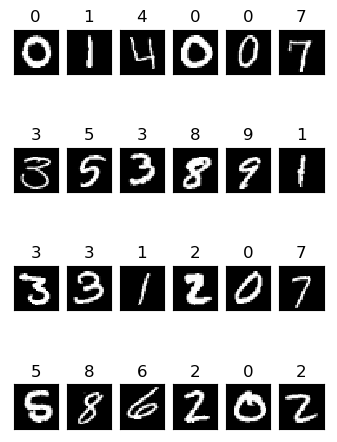

In [5]:
#visulaizing numbers in our dataset.
r = 4
c = 6
fig=plt.figure(figsize=(r, c),dpi=100)
for i in range(1, r*c+1):
    img = X[i]
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(Y[i])
    
    plt.imshow(img,cmap='gray')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.2)

In [7]:
import mxnet as mx
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn
import mxnet.ndarray as F

class Net(gluon.Block):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            
            self.cnn1 = nn.Conv2D(20,kernel_size=(4,4))
            self.mxp1 = nn.MaxPool2D((2,2))
            
            self.cnn2 = nn.Conv2D(25,kernel_size=(2,2))
            self.mxp2 = nn.MaxPool2D((2,2))
            
            self.cnn3 = nn.Conv2D(30,kernel_size=(2,2))
            self.mxp3 = nn.MaxPool2D((2,2))
            
            self.flat = nn.Flatten()
            
            self.fc = nn.Dense(128)
            self.out = nn.Dense(10)
            
    def forward(self,x):
        
        x = F.relu(self.mxp1(self.cnn1(x)))
        x = F.relu(self.mxp2(self.cnn2(x)))
        x = F.relu(self.mxp3(self.cnn3(x)))
        x = self.flat(x)
        x = F.relu(self.fc(x))
        x = self.out(x)
        
        return x
    
Model = Net()
print(Model)

Net(
  (cnn1): Conv2D(None -> 20, kernel_size=(4, 4), stride=(1, 1))
  (mxp1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (cnn2): Conv2D(None -> 25, kernel_size=(2, 2), stride=(1, 1))
  (mxp2): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (cnn3): Conv2D(None -> 30, kernel_size=(2, 2), stride=(1, 1))
  (mxp3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (flat): Flatten
  (fc): Dense(None -> 128, linear)
  (out): Dense(None -> 10, linear)
)


In [8]:
device = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)
Model.initialize(mx.init.Xavier(), ctx=device)

In [9]:
trainer = gluon.Trainer(
    params=Model.collect_params(),
    optimizer='adam',
    optimizer_params={'learning_rate': 0.01},
)

In [10]:
accuracy_fn = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
ce_loss = mx.metric.CrossEntropy()

In [11]:
#converting our numpy array into mxnet.nd.array
#channel first
trn_x = nd.array(trn_x).reshape(-1,1,28,28)
trn_y = nd.array(trn_y)

val_x = nd.array(val_x).reshape(-1,1,28,28)
val_y = nd.array(val_y)

In [12]:
def reset_metrics():
    accuracy_fn.reset()
    ce_loss.reset()

In [13]:
def get_loss_acc(iterator,Model,loss_function,accuracy_function):
    
    loss_of_batches = []
    acc_of_batches = []
    
    for batch in iterator:
        x = batch.data[0].as_in_context(device)
        y = batch.label[0].as_in_context(device)
    
        output = Model(x)
        accuracy_function.update(y,output)
        loss_function.update(y,F.softmax(output))
        
        _,acc = accuracy_function.get()
        _,loss = loss_function.get()
        
        loss_of_batches.append(loss)
        acc_of_batches.append(acc)
        reset_metrics()
    

    return np.mean(loss_of_batches), np.mean(acc_of_batches)

In [14]:
EPOCHS = 15
trn_loss = []
val_loss = []

train_iter = mx.io.NDArrayIter(trn_x, trn_y, 1000, shuffle=True)
val_iter = mx.io.NDArrayIter(val_x, val_y, 1000, shuffle=True)

for epoch in range(EPOCHS):
    
    for trn_batch in train_iter:

        x = trn_batch.data[0].as_in_context(device)
        y = trn_batch.label[0].as_in_context(device)
        
        with autograd.record():
            y_pred = Model(x)
            loss = loss_function(y_pred, y)
        
        #backprop
        loss.backward()
        
        #Optimize!
        trainer.step(batch_size=trn_x.shape[0])
        
    train_iter.reset()

    """ Calculate train metrics """
    loss,trn_acc = get_loss_acc(train_iter,Model,ce_loss,accuracy_fn)
    trn_loss.append(loss)
    train_iter.reset()

    
    
    """ Calculate val metrics """
    
    loss,val_acc = get_loss_acc(val_iter,Model,ce_loss,accuracy_fn)
    val_loss.append(loss)
    val_iter.reset()
    
    print("epoch: {} | trn_loss: {:.4f} | trn_acc: {:.4f} | val_loss: {:.4f} | val_acc: {:.4f}".format(
                                                        epoch+1,
                                                        trn_loss[-1],
                                                        trn_acc,
                                                        val_loss[-1],
                                                         val_acc))

epoch: 1 | trn_loss: 0.2348 | trn_acc: 0.9301 | val_loss: 0.2447 | val_acc: 0.9269
epoch: 2 | trn_loss: 0.1054 | trn_acc: 0.9688 | val_loss: 0.1162 | val_acc: 0.9619
epoch: 3 | trn_loss: 0.0804 | trn_acc: 0.9749 | val_loss: 0.0981 | val_acc: 0.9681
epoch: 4 | trn_loss: 0.0644 | trn_acc: 0.9791 | val_loss: 0.0864 | val_acc: 0.9731
epoch: 5 | trn_loss: 0.0659 | trn_acc: 0.9784 | val_loss: 0.0907 | val_acc: 0.9714
epoch: 6 | trn_loss: 0.0472 | trn_acc: 0.9846 | val_loss: 0.0706 | val_acc: 0.9787
epoch: 7 | trn_loss: 0.0413 | trn_acc: 0.9871 | val_loss: 0.0721 | val_acc: 0.9782
epoch: 8 | trn_loss: 0.0298 | trn_acc: 0.9906 | val_loss: 0.0642 | val_acc: 0.9813
epoch: 9 | trn_loss: 0.0479 | trn_acc: 0.9830 | val_loss: 0.0890 | val_acc: 0.9763
epoch: 10 | trn_loss: 0.0227 | trn_acc: 0.9926 | val_loss: 0.0573 | val_acc: 0.9852
epoch: 11 | trn_loss: 0.0247 | trn_acc: 0.9919 | val_loss: 0.0626 | val_acc: 0.9818
epoch: 12 | trn_loss: 0.0221 | trn_acc: 0.9926 | val_loss: 0.0692 | val_acc: 0.9814
e

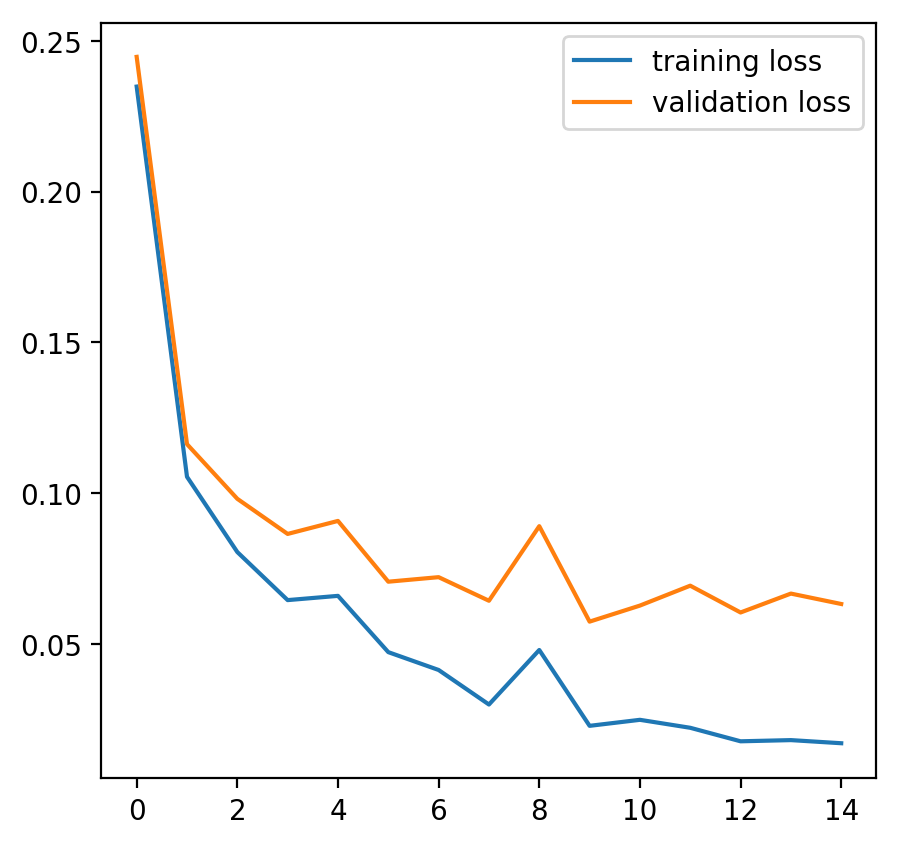

In [15]:
plt.figure(figsize=(5,5),dpi=200)
plt.plot(trn_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='upper right')

In [16]:
pred = Model(val_x.as_in_context(device))
predictions = []

for p in pred.asnumpy():
    predictions.append(np.argmax(p,axis=0))

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_y.asnumpy(),predictions)

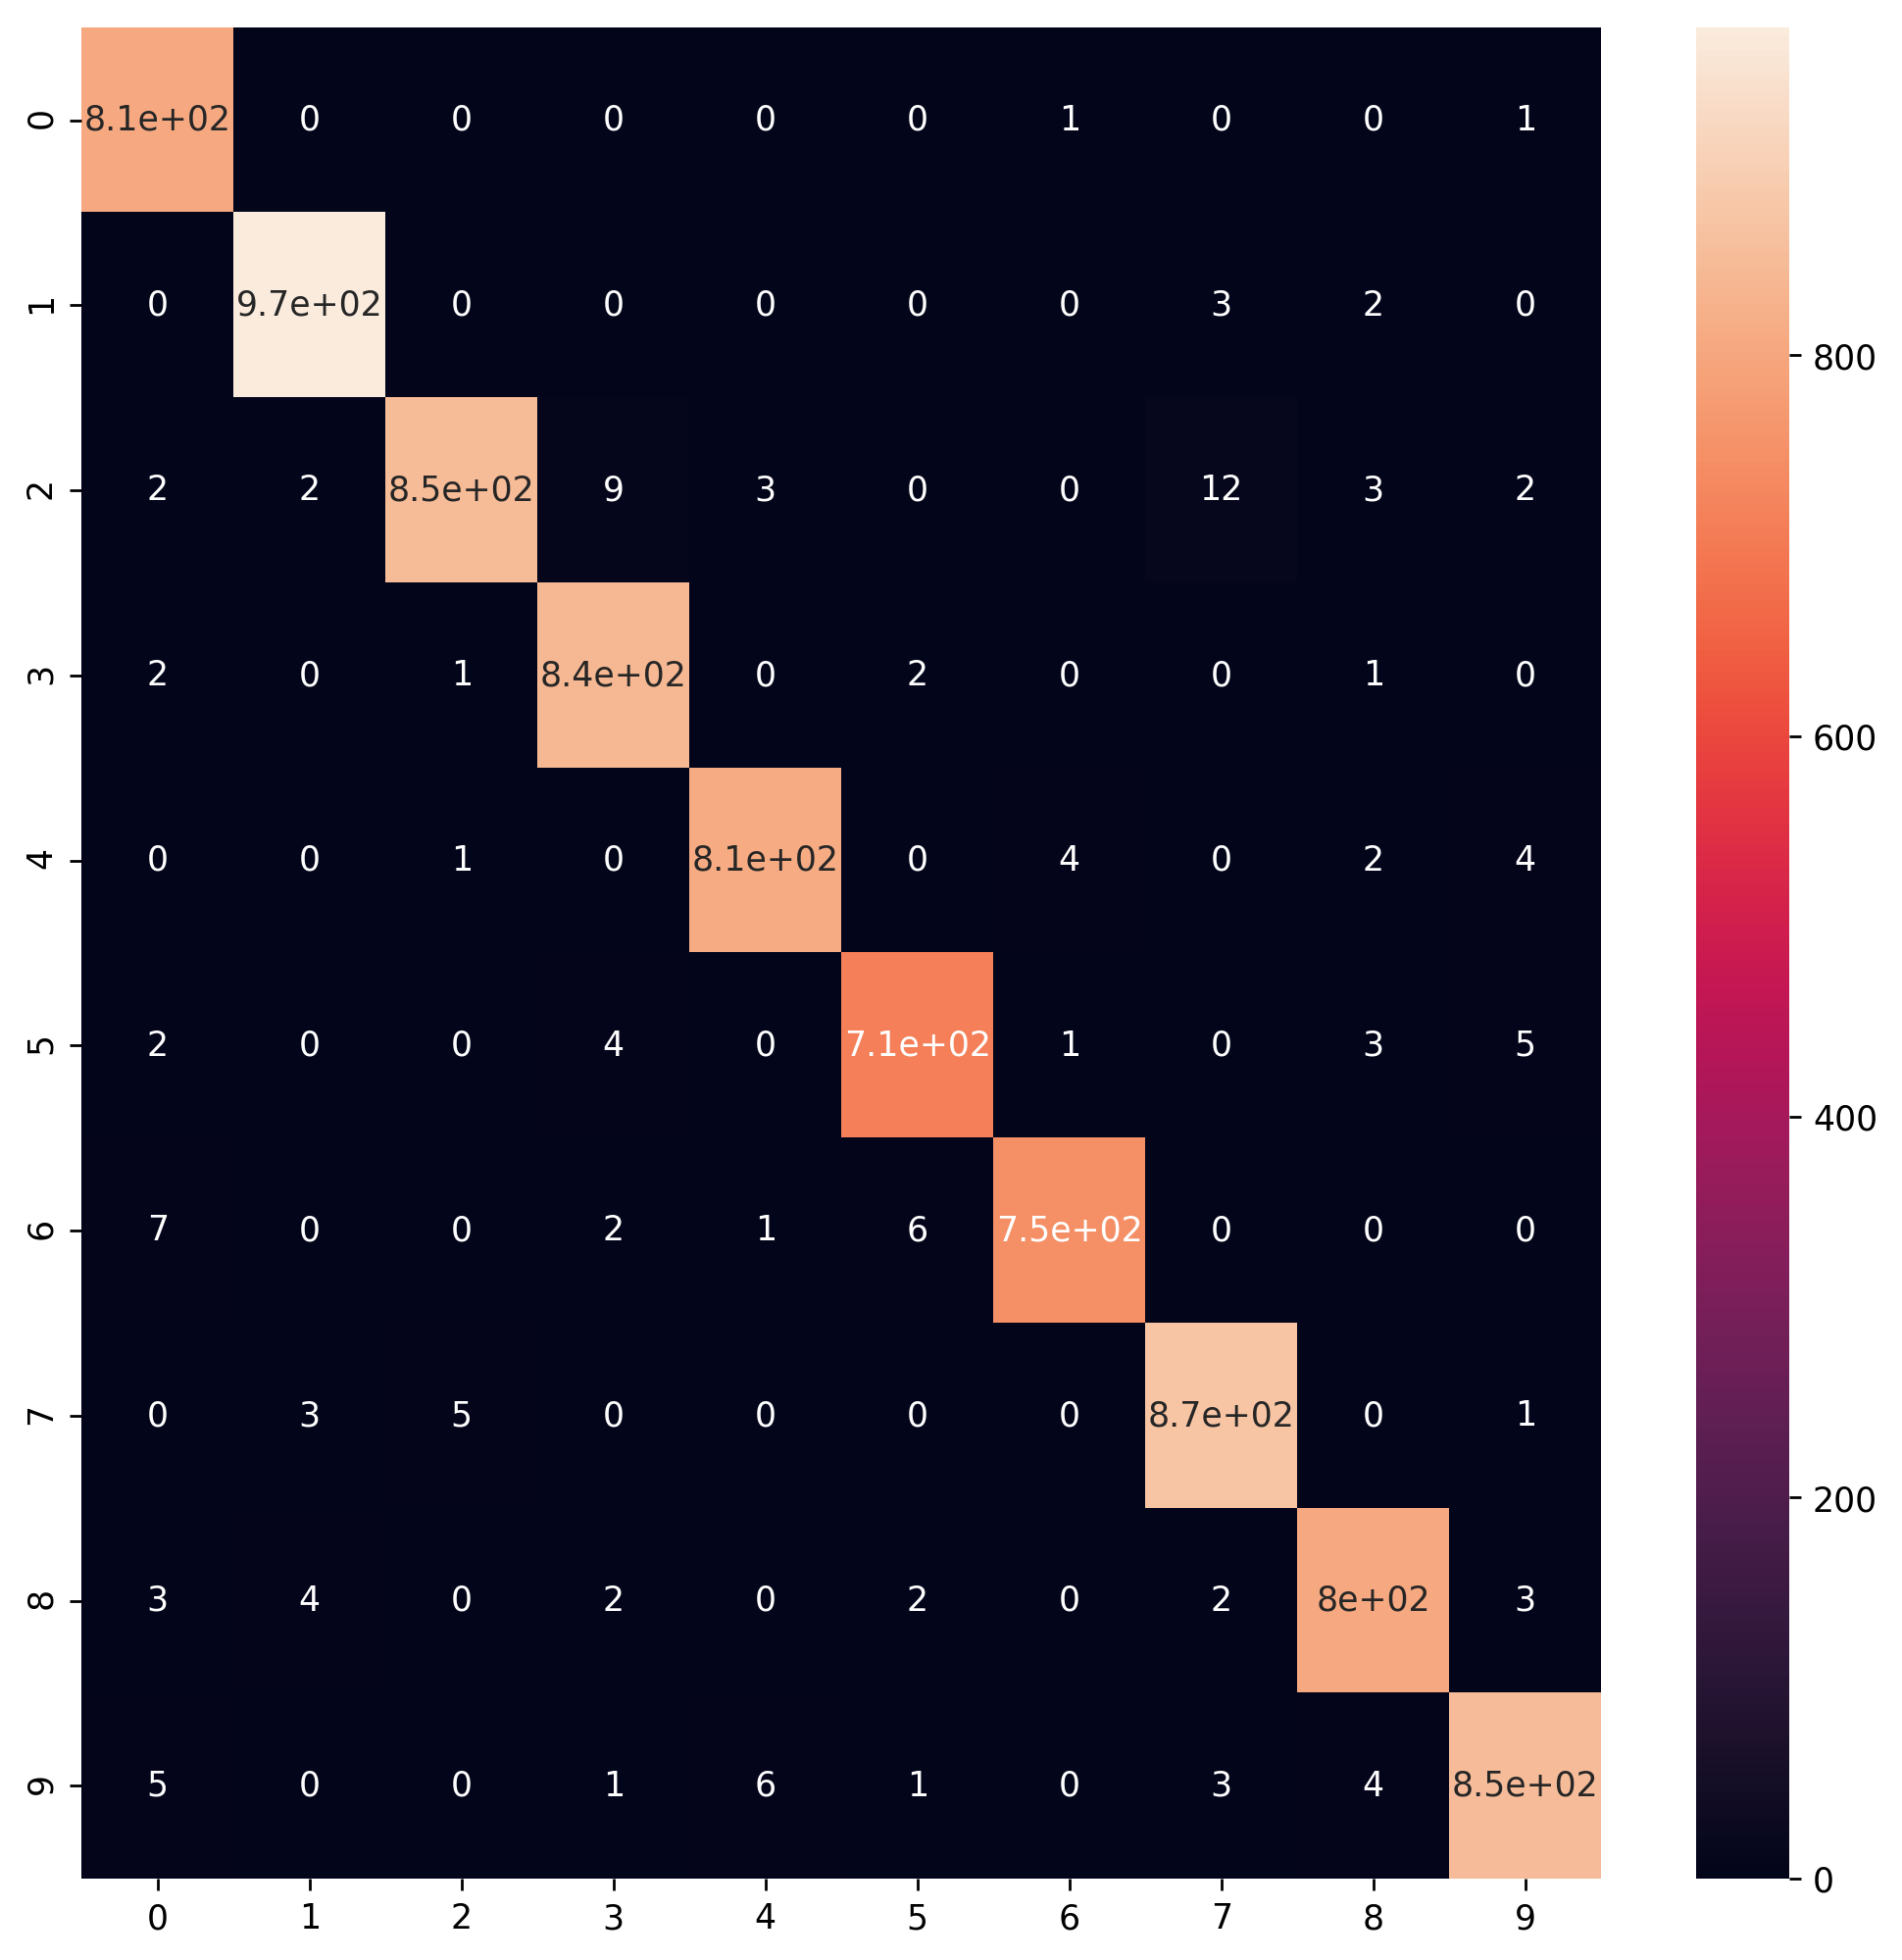

In [18]:
plt.figure(figsize = (10,10),dpi=250)
seaborn.heatmap(cm,annot=True)

In [19]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(val_y.asnumpy(),predictions)

print("Accuracy:",acc*100,"%")

Accuracy: 98.4166666667 %
